In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc # for garbage collection

## Introduction

This notebook focuses on trying to solve th competition problem available on Zindi Loan Default Prediction.

SuperLender is a local digital lending company, which prides itself in its effective use of credit risk models to deliver profitable and high-impact loan alternative. Its assessment approach is based on two main risk drivers of loan default prediction:. 1) willingness to pay and 2) ability to pay. Since not all customers pay back, the company invests in experienced data scientist to build robust models to effectively predict the odds of repayment.

There are 3 datasets for both the train and test dataframes.
Demographic data (traindemographics.csv)
Performance data (trainperf.csv): this is the loan application for which we need to predict for. 
Good loan = 1, Bad loan = 0
Previous loans data (trainprevloans.csv): This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of

In [2]:
train = pd.read_csv('../input/dataset/trainperf.csv')
test = pd.read_csv('../input/dataset/testperf.csv')

train_demographics = pd.read_csv('../input/dataset/traindemographics.csv')
test_demographics = pd.read_csv('../input/dataset/testdemographics.csv')

train_prev = pd.read_csv('../input/dataset/trainprevloans.csv')
test_prev = pd.read_csv('../input/dataset/testprevloans.csv')

In [3]:
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


We see that the target we're trying to predict is the good_bad_flag column on the train dataset. Let's see the distribution of the target

Text(0, 0.5, 'count')

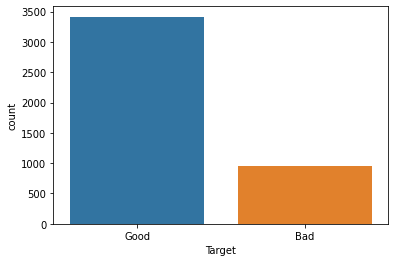

In [4]:
fig = sns.countplot(x='good_bad_flag', data=train)
fig.set_xlabel('Target')
fig.set_ylabel('count')

We can understand that we have a very imbalanced dataset with most of the target being Good. 

In [5]:
train['good_bad_flag'].value_counts()

Good    3416
Bad      952
Name: good_bad_flag, dtype: int64

We see that the majority class has  ~3.5x more observations. Let's encode the target according to the instruction set by the competition. That is, Good = 1, Bad = 0

In [6]:
target_mapping = {'Good': 1, 'Bad': 0}
train['good_bad_flag'] = train['good_bad_flag'].map(target_mapping)

# let's see the value counts again
train['good_bad_flag'].value_counts()

1    3416
0     952
Name: good_bad_flag, dtype: int64

In [7]:
test.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,NaN


In [8]:
train.shape, test.shape

((4368, 10), (1450, 9))

## Exploratory Data Analysis

Let's begin with exploratory data analysis on the different datasets we're given. But first, let's write some simple utility function that will help us in doing so

In [9]:
def missing_values_table(df):
    """Returns a dataframe of number of missing entries per column in df"""
    miss_val = df.isnull().sum()
    miss_val_percent = (df.isnull().sum() * 100) / len(df)
    miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)
    miss_val_table = miss_val_table.rename(columns={0:'Missing Values', 1: '% of Missing Values'})
    
    # sort by mssing values
    miss_val_table = miss_val_table[miss_val_table.iloc[:,1] != 0].sort_values('% of Missing Values', ascending=False).round(1)
     # print some summary information
    print(f'The dataframe has {str(df.shape[1])} columns.\nThere are {str(miss_val_table.shape[0])} columns with missing values')
    return miss_val_table

In [10]:
# this function does the same as above but also includes datatypes
def quality_report(df):
    """Performs a quaity report of df based on unique values, missing values, missing values % and datatype"""
    
    dtypes = df.dtypes
    nuniq = df.T.apply(lambda x: x.nunique(), axis=1)
    total_null = df.isnull().sum()
    percent_null = (100* df.isnull().sum())/len(df)
    
    quality_df = pd.concat([total_null, percent_null, nuniq,dtypes],axis=1, keys=['Total Null', 'Percent Null', 'No. of Unique'
                                                                                , 'datatypes'])
    # sort by % of missing values
    quality_df = quality_df.sort_values(by='Percent Null', ascending=False).round(1)
    return quality_df

### Train and Test

In [11]:
missing_values_table(train)

The dataframe has 10 columns.
There are 1 columns with missing values


,Missing Values,% of Missing Values
referredby,3781,86.6


In [12]:
quality_report(train)

,Total Null,Percent Null,No. of Unique,datatypes
referredby,3781,86.6,521,object
customerid,0,0.0,4368,object
systemloanid,0,0.0,4368,int64
loannumber,0,0.0,23,int64
approveddate,0,0.0,4362,object
creationdate,0,0.0,4364,object
loanamount,0,0.0,10,float64
totaldue,0,0.0,47,float64
termdays,0,0.0,4,int64
good_bad_flag,0,0.0,2,int64


In [13]:
missing_values_table(test)

The dataframe has 9 columns.
There are 1 columns with missing values


,Missing Values,% of Missing Values
referredby,1266,87.3


In [14]:
# let's drop the referredby column in both train and test
train = train.drop(columns='referredby')
test = test.drop(columns='referredby')

train.shape, test.shape

((4368, 9), (1450, 8))

In [15]:
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,1


### Demographics

Let's engineer some features from the demographics csv

In [16]:
train_demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [17]:
missing_values_table(train_demographics)

The dataframe has 9 columns.
There are 3 columns with missing values


,Missing Values,% of Missing Values
bank_branch_clients,4295,98.8
level_of_education_clients,3759,86.5
employment_status_clients,648,14.9


In [18]:
missing_values_table(test_demographics)

The dataframe has 9 columns.
There are 3 columns with missing values


,Missing Values,% of Missing Values
bank_branch_clients,1473,99.1
level_of_education_clients,1277,85.9
employment_status_clients,217,14.6


In [19]:
cols = ['bank_branch_clients', 'level_of_education_clients']

train_demographics = train_demographics.drop(columns=cols)
test_demographics = test_demographics.drop(columns=cols)

In [20]:
# let's see the categorical columns to encode
columns = train_demographics.select_dtypes(include='object').columns
columns

Index(['customerid', 'birthdate', 'bank_account_type', 'bank_name_clients',
       'employment_status_clients'],
      dtype='object')

From observation, we need to encode the bank_account_type, bank_name_clients and employment_status_clients features

In [21]:
train_demographics['bank_name_clients'].value_counts()

GT Bank               1598
First Bank             590
Access Bank            432
UBA                    353
Zenith Bank            301
Diamond Bank           282
EcoBank                150
Stanbic IBTC           145
FCMB                   121
Fidelity Bank          103
Skye Bank              102
Sterling Bank           55
Wema Bank               28
Union Bank              23
Heritage Bank           22
Keystone Bank           19
Standard Chartered      15
Unity Bank               7
Name: bank_name_clients, dtype: int64

In [22]:
#label encode bank_name_clients

from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
label_encode.fit(train_demographics['bank_name_clients'])
train_demographics['bank_name_clients'] = label_encode.transform(train_demographics['bank_name_clients'])
test_demographics['bank_name_clients'] = label_encode.transform(test_demographics['bank_name_clients'])

train_demographics.shape, test_demographics.shape

((4346, 7), (1487, 7))

In [23]:
train_demographics['bank_account_type'].value_counts()

Savings    3425
Other       865
Current      56
Name: bank_account_type, dtype: int64

In [24]:
# let's ohe this feature
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(train_demographics[['bank_account_type']])

# for train
temp = ohe.transform(train_demographics[['bank_account_type']]).toarray()
train_demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
train_demographics = pd.concat([train_demographics, train_demographics_ohe], axis=1).drop(columns=['bank_account_type'])

# and for test
temp = ohe.transform(test_demographics[['bank_account_type']]).toarray()
test_demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
test_demographics = pd.concat([test_demographics, test_demographics_ohe], axis=1).drop(columns=['bank_account_type'])
train_demographics.shape, test_demographics.shape

((4346, 9), (1487, 9))

In [25]:
# for the employment_status_clients
train_demographics['employment_status_clients'].value_counts()

Permanent        3146
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64

In [26]:
train_demographics['employment_status_clients'].isnull().sum()

648

In [27]:
train_demographics['employment_status_clients'] = train_demographics['employment_status_clients'].fillna('NONE')
test_demographics['employment_status_clients'] = test_demographics['employment_status_clients'].fillna('NONE')

train_demographics['employment_status_clients'].value_counts()

Permanent        3146
NONE              648
Self-Employed     348
Student           142
Unemployed         57
Retired             4
Contract            1
Name: employment_status_clients, dtype: int64

In [28]:
# let's onehotencode this feature

ohe = OneHotEncoder()
ohe.fit(train_demographics[['employment_status_clients']])

# for train
temp = ohe.transform(train_demographics[['employment_status_clients']]).toarray()
train_demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
train_demographics = pd.concat([train_demographics, train_demographics_ohe], axis=1).drop(columns=['employment_status_clients'])

# and for test
temp = ohe.transform(test_demographics[['employment_status_clients']]).toarray()
test_demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
test_demographics = pd.concat([test_demographics, test_demographics_ohe], axis=1).drop(columns=['employment_status_clients'])

train_demographics.shape, test_demographics.shape

((4346, 15), (1487, 15))

In [29]:
# I find it doubtful the longitude_gps and latitude_gps will help in assisting... so let's drop them
train_demographics.drop(columns=['latitude_gps', 'longitude_gps'], inplace=True)
test_demographics.drop(columns=['latitude_gps', 'longitude_gps'], inplace=True)

In [30]:
train_demographics.head()

,customerid,birthdate,bank_name_clients,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,6,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,12,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
# let's merge these features with the train and test sets respectivly
print(train.shape, test.shape)

train = train.merge(train_demographics, on='customerid', how='left') # using only keys from the train
test = test.merge(test_demographics, on='customerid', how='left')

print(train.shape, test.shape)

(4368, 9) (1450, 8)
(4376, 21) (1450, 20)


In [32]:
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,1,1972-01-15 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,1,1985-08-23 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,1,1984-09-18 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,1,1977-10-10 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,1,1986-09-07 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [33]:
missing_values_table(train)

The dataframe has 21 columns.
There are 12 columns with missing values


,Missing Values,% of Missing Values
birthdate,1099,25.1
bank_name_clients,1099,25.1
bank_account_type_Current,1099,25.1
bank_account_type_Other,1099,25.1
bank_account_type_Savings,1099,25.1
employment_status_clients_Contract,1099,25.1
employment_status_clients_NONE,1099,25.1
employment_status_clients_Permanent,1099,25.1
employment_status_clients_Retired,1099,25.1
employment_status_clients_Self-Employed,1099,25.1


In [34]:
missing_values_table(test)

The dataframe has 20 columns.
There are 12 columns with missing values


,Missing Values,% of Missing Values
birthdate,1065,73.4
bank_name_clients,1065,73.4
bank_account_type_Current,1065,73.4
bank_account_type_Other,1065,73.4
bank_account_type_Savings,1065,73.4
employment_status_clients_Contract,1065,73.4
employment_status_clients_NONE,1065,73.4
employment_status_clients_Permanent,1065,73.4
employment_status_clients_Retired,1065,73.4
employment_status_clients_Self-Employed,1065,73.4


#### Problems

1. It appears we have duplicate rows in the train dataset since we have increased number of rows before and after merging - from 4368 to 4376. Let's check for duplicates and drop them
2. There are some clients with customer id in train missing in train demographics and same for test, since we seem to have a high number of missing features from some rows. To fix let's merge each with the other demographics

In [35]:
# fix the duplicate rows issue
duplicate = train[train.duplicated(subset='customerid')]
 
duplicate

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
522,8a858fe65675195a015679452588279c,301973257,10,2017-07-11 15:36:56.000000,2017-07-11 14:35:45.000000,40000.0,48000.0,60,1,1982-08-01 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
894,8a858f9f5679951a01567a5b90644817,301969153,3,2017-07-08 12:06:02.000000,2017-07-08 11:05:55.000000,10000.0,13000.0,30,1,1984-12-17 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1073,8a858e6c5c88d145015c8b9627cd5a48,301973324,2,2017-07-11 16:11:39.000000,2017-07-11 15:11:33.000000,10000.0,13000.0,30,1,1979-09-30 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1604,8a858ec65cc6352b015cc64525ea0763,301968904,2,2017-07-08 08:12:37.000000,2017-07-08 07:12:31.000000,10000.0,13000.0,30,1,1985-01-30 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2385,8a858fe05d421ff4015d4c87d2a21ceb,301994359,2,2017-07-24 22:34:06.000000,2017-07-24 21:33:55.000000,10000.0,13000.0,30,0,1983-01-20 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2665,8a858f1e5cc4bc81015cc548e1eb5206,301982397,2,2017-07-17 17:40:43.000000,2017-07-17 16:40:37.000000,10000.0,13000.0,30,1,1979-09-15 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3789,8a858fc75cd62882015cdaf2f4311b3f,301983655,2,2017-07-18 11:54:58.000000,2017-07-18 10:54:53.000000,10000.0,11500.0,15,1,1975-10-27 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3898,8a858f1e5baffcc9015bb02b505f180d,301983018,5,2017-07-18 05:29:21.000000,2017-07-18 04:29:12.000000,20000.0,24500.0,30,1,1983-04-06 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [36]:
train.drop_duplicates(subset='customerid', keep='first', inplace=True)
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,1,1972-01-15 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,1,1985-08-23 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,1,1984-09-18 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,1,1977-10-10 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,1,1986-09-07 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [37]:
train.shape, test.shape

((4368, 21), (1450, 20))

Before moving on to the last prev applications dataframes, let's see the corr matrix

In [38]:
corr = train.corr()['good_bad_flag']
corr.sort_values(ascending=False)

good_bad_flag                              1.000000
loanamount                                 0.115267
totaldue                                   0.108357
bank_account_type_Other                    0.100836
loannumber                                 0.090487
employment_status_clients_Permanent        0.048247
employment_status_clients_Self-Employed    0.041006
bank_account_type_Current                  0.031653
employment_status_clients_Retired          0.018486
employment_status_clients_Unemployed       0.015466
employment_status_clients_Contract         0.009239
systemloanid                               0.007048
termdays                                   0.005160
bank_name_clients                         -0.004629
employment_status_clients_Student         -0.023680
employment_status_clients_NONE            -0.087914
bank_account_type_Savings                 -0.107423
Name: good_bad_flag, dtype: float64

Text(0.5, 1.0, 'Distribution of Loan Amount')

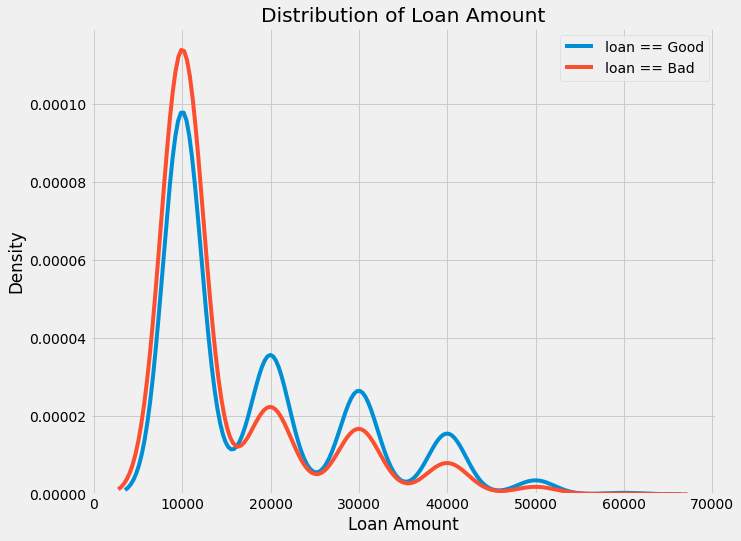

In [39]:
# let's plot a KDE for the loanamount

plt.style.use('fivethirtyeight')
plt.figure(figsize = (10, 8))

# KDE plot good loans
sns.kdeplot(train.loc[train['good_bad_flag'] == 1, 'loanamount'], label = 'loan == Good')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['good_bad_flag'] == 0, 'loanamount'], label = 'loan == Bad')

# Labeling of plot
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Loan Amount')

Text(0.5, 1.0, 'Distribution of Loan Amount')

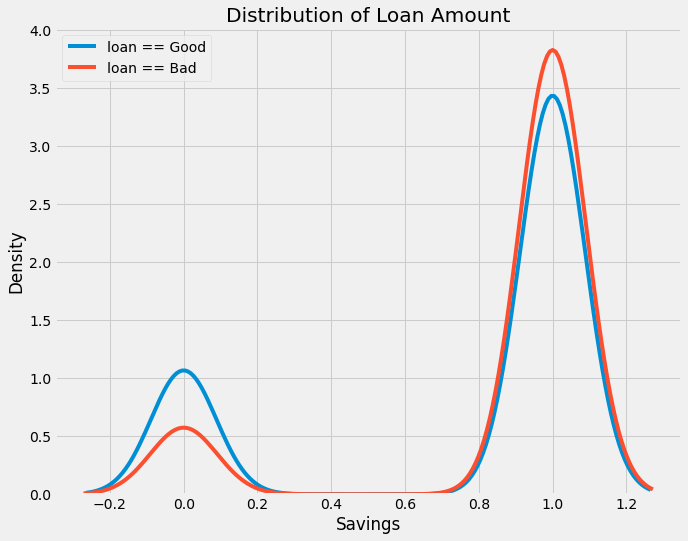

In [40]:
# let's plot a KDE for the bank_account_type_Savings
plt.figure(figsize = (10, 8))

# KDE plot good loans
sns.kdeplot(train.loc[train['good_bad_flag'] == 1, 'bank_account_type_Savings'], label = 'loan == Good')

# KDE plot of loans which were not repaid on time
sns.kdeplot(train.loc[train['good_bad_flag'] == 0, 'bank_account_type_Savings'], label = 'loan == Bad')

# Labeling of plot
plt.xlabel('Savings')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of Loan Amount')

These KDE plots don't tell us much. Let's explore features from the Previous loans

In [41]:
del train_demographics, test_demographics, temp

gc.collect()

21

### Prev Loans

In [42]:
train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [43]:
missing_values_table(train_prev)

The dataframe has 12 columns.
There are 1 columns with missing values


,Missing Values,% of Missing Values
referredby,17157,94.4


In [44]:
train_prev.drop(columns=['referredby'], inplace=True)
test_prev.drop(columns=['referredby'], inplace=True)

In [45]:
# let's look at the train_prev again
train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


There are several columns in the dataframe with information relating to date but on looking at the entries, they're not in the proper data type. Let's see this and work on it

In [46]:
# first, let's see the datatypes
train_prev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       18183 non-null  object 
 1   systemloanid     18183 non-null  int64  
 2   loannumber       18183 non-null  int64  
 3   approveddate     18183 non-null  object 
 4   creationdate     18183 non-null  object 
 5   loanamount       18183 non-null  float64
 6   totaldue         18183 non-null  float64
 7   termdays         18183 non-null  int64  
 8   closeddate       18183 non-null  object 
 9   firstduedate     18183 non-null  object 
 10  firstrepaiddate  18183 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.5+ MB


In [47]:
date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']

# we only need the date info, so we drop the time info from the columns

for date in date_cols:
    train_prev[date] = pd.to_datetime(train_prev[date]).dt.date
    test_prev[date] = pd.to_datetime(test_prev[date]).dt.date

train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15,2016-08-15,10000.0,13000.0,30,2016-09-01,2016-09-14,2016-09-01
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28,2017-04-28,10000.0,13000.0,30,2017-05-28,2017-05-30,2017-05-26
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05,2017-03-05,20000.0,23800.0,30,2017-04-26,2017-04-04,2017-04-26
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09,2017-04-09,10000.0,11500.0,15,2017-04-24,2017-04-24,2017-04-24
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17,2017-06-17,10000.0,11500.0,15,2017-07-14,2017-07-03,2017-07-14


In [48]:
# let's create features based on the dates

# prev_loan_duration
train_prev['loanduration'] = train_prev['closeddate'] - train_prev['approveddate']
test_prev['loanduration'] = test_prev['closeddate'] - test_prev['approveddate']

# days_to_approve
train_prev['daysapproved'] = train_prev['approveddate'] - train_prev['creationdate']
test_prev['daysapproved'] = test_prev['approveddate'] - test_prev['creationdate']

# first_repay_days
train_prev['repaydays'] = train_prev['firstrepaiddate'] - train_prev['firstduedate']
test_prev['repaydays'] = test_prev['firstrepaiddate'] - test_prev['firstduedate']

# interest
train_prev['interest'] = train_prev['totaldue'] - train_prev['loanamount']
test_prev['interest'] = test_prev['totaldue'] - test_prev['loanamount']

train_prev.shape, test_prev.shape

((18183, 15), (5907, 15))

In [49]:
train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,loanduration,daysapproved,repaydays,interest
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15,2016-08-15,10000.0,13000.0,30,2016-09-01,2016-09-14,2016-09-01,17 days,0 days,-13 days,3000.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28,2017-04-28,10000.0,13000.0,30,2017-05-28,2017-05-30,2017-05-26,30 days,0 days,-4 days,3000.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05,2017-03-05,20000.0,23800.0,30,2017-04-26,2017-04-04,2017-04-26,52 days,0 days,22 days,3800.0
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09,2017-04-09,10000.0,11500.0,15,2017-04-24,2017-04-24,2017-04-24,15 days,0 days,0 days,1500.0
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17,2017-06-17,10000.0,11500.0,15,2017-07-14,2017-07-03,2017-07-14,27 days,0 days,11 days,1500.0


In [50]:
# let's convert those daysapproved, repaydays and loanduration to int

datecols = ['loanduration', 'daysapproved', 'repaydays']

for col in datecols:
    train_prev[col] = (train_prev[col] / np.timedelta64(1, 'D')).astype(int)
    test_prev[col] = (test_prev[col] / np.timedelta64(1, 'D')).astype(int)
    
train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,loanduration,daysapproved,repaydays,interest
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15,2016-08-15,10000.0,13000.0,30,2016-09-01,2016-09-14,2016-09-01,17,0,-13,3000.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28,2017-04-28,10000.0,13000.0,30,2017-05-28,2017-05-30,2017-05-26,30,0,-4,3000.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05,2017-03-05,20000.0,23800.0,30,2017-04-26,2017-04-04,2017-04-26,52,0,22,3800.0
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09,2017-04-09,10000.0,11500.0,15,2017-04-24,2017-04-24,2017-04-24,15,0,0,1500.0
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17,2017-06-17,10000.0,11500.0,15,2017-07-14,2017-07-03,2017-07-14,27,0,11,1500.0


Let's engineer some features from the dataframe

In [51]:
train_prev_counts = train_prev.groupby('customerid', as_index=False)['systemloanid'].count().rename(columns={'systemloanid': 'prev_applications'})
train_prev_counts

,customerid,prev_applications
0,8a1088a0484472eb01484669e3ce4e0b,1
1,8a1a1e7e4f707f8b014f797718316cad,4
2,8a1a32fc49b632520149c3b8fdf85139,7
3,8a1eb5ba49a682300149c3c068b806c7,8
4,8a1edbf14734127f0147356fdb1b1eb2,2
...,...,...
4354,8a858fff5a28d297015a33bc2e845305,6
4355,8a858fff5a36fe68015a37f8550a02a2,6
4356,8a858fff5a36fe68015a3ac5851618ab,1
4357,8a858fff5a36fe68015a3b8dcb8a3843,6


In [52]:
test_prev_counts = test_prev.groupby('customerid', as_index=False)['systemloanid'].count().rename(columns={'systemloanid': 'prev_applications'})

In [53]:
# for train
# term days
avg_termdays = train_prev.groupby('customerid', as_index=False)['termdays'].mean().rename(columns={'termdays': 'prevtermdays_norm'})
sum_termdays = train_prev.groupby('customerid', as_index=False)['termdays'].sum().rename(columns={'termdays': 'prevtermdays_sum'})

# loan amount
avg_loanamnt = train_prev.groupby('customerid', as_index=False)['loanamount'].mean().rename(columns={'loanamount': 'prevloanamount_norm'})
sum_loanamnt = train_prev.groupby('customerid', as_index=False)['loanamount'].sum().rename(columns={'loanamount': 'prevloanamount_sum'})

# totaldue
avg_totaldue = train_prev.groupby('customerid', as_index=False)['totaldue'].mean().rename(columns={'totaldue': 'totaldue_norm'})
sum_totaldue = train_prev.groupby('customerid', as_index=False)['totaldue'].sum().rename(columns={'totaldue': 'totaldue_sum'})

# interest
avg_interest = train_prev.groupby('customerid', as_index=False)['interest'].mean().rename(columns={'interest': 'previnterest_norm'})
total_interest = train_prev.groupby('customerid', as_index=False)['interest'].sum().rename(columns={'interest': 'previnterest_sum'})

# repay days
avg_repaydays = train_prev.groupby('customerid', as_index=False)['repaydays'].mean().rename(columns={'repaydays': 'prevrepaydays_norm'})
total_repaydays = train_prev.groupby('customerid', as_index=False)['repaydays'].sum().rename(columns={'repaydays':'prevrepaydays_sum'})

# daysapproved
avg_daysapproved = train_prev.groupby('customerid', as_index=False)['daysapproved'].mean().rename(columns={'daysapproved': 'prevdaysapproved_norm'})
total_daysapproved = train_prev.groupby('customerid', as_index=False)['daysapproved'].sum().rename(columns={'daysapproved': 'prevdaysapproved_sum'})

# loanduration
avg_loanduration = train_prev.groupby('customerid', as_index=False)['loanduration'].mean().rename(columns={'loanduration': 'prevloanduration_norm'})
total_loanduration = train_prev.groupby('customerid', as_index=False)['loanduration'].sum().rename(columns={'loanduration': 'prevloanduration_sum'})

In [54]:
# let's merge these features
trainprev_features = train_prev_counts.merge(avg_termdays, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(sum_termdays, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_loanamnt, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(sum_loanamnt, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_totaldue, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(sum_totaldue, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_interest, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(total_interest, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_repaydays, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(total_repaydays, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_daysapproved, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(total_daysapproved, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(avg_loanduration, on='customerid', how='inner')
trainprev_features = trainprev_features.merge(total_loanduration, on='customerid', how='inner')


trainprev_features.head()

,customerid,prev_applications,prevtermdays_norm,prevtermdays_sum,prevloanamount_norm,prevloanamount_sum,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a1088a0484472eb01484669e3ce4e0b,1,15.000000,15,10000.000000,10000.0,11500.000000,11500.0,1500.000000,1500.0,6.000000,6,0.0,0,22.000,22
1,8a1a1e7e4f707f8b014f797718316cad,4,37.500000,150,17500.000000,70000.0,22375.000000,89500.0,4875.000000,19500.0,-0.250000,-1,0.0,0,31.750,127
2,8a1a32fc49b632520149c3b8fdf85139,7,19.285714,135,12857.142857,90000.0,15214.285714,106500.0,2357.142857,16500.0,-0.428571,-3,0.0,0,19.000,133
3,8a1eb5ba49a682300149c3c068b806c7,8,33.750000,270,16250.000000,130000.0,20300.000000,162400.0,4050.000000,32400.0,-3.125000,-25,0.0,0,28.625,229
4,8a1edbf14734127f0147356fdb1b1eb2,2,22.500000,45,10000.000000,20000.0,12250.000000,24500.0,2250.000000,4500.0,-4.000000,-8,0.0,0,18.500,37


In [55]:
# for the test
# for test 
testavg_termdays = test_prev.groupby('customerid', as_index=False)['termdays'].mean().rename(columns={'termdays': 'prevtermdays_norm'})
testsum_termdays = test_prev.groupby('customerid', as_index=False)['termdays'].sum().rename(columns={'termdays': 'prevtermdays_sum'})

# loan amount
testavg_loanamnt = test_prev.groupby('customerid', as_index=False)['loanamount'].mean().rename(columns={'loanamount': 'prevloanamount_norm'})
testsum_loanamnt = test_prev.groupby('customerid', as_index=False)['loanamount'].sum().rename(columns={'loanamount': 'prevloanamount_sum'})

# totaldue
testavg_totaldue = test_prev.groupby('customerid', as_index=False)['totaldue'].mean().rename(columns={'totaldue': 'totaldue_norm'})
testsum_totaldue = test_prev.groupby('customerid', as_index=False)['totaldue'].sum().rename(columns={'totaldue': 'totaldue_sum'})

# interest
testavg_interest = test_prev.groupby('customerid', as_index=False)['interest'].mean().rename(columns={'interest': 'previnterest_norm'})
testtotal_interest = test_prev.groupby('customerid', as_index=False)['interest'].sum().rename(columns={'interest': 'previnterest_sum'})

# repay days
testavg_repaydays = test_prev.groupby('customerid', as_index=False)['repaydays'].mean().rename(columns={'repaydays': 'prevrepaydays_norm'})
testtotal_repaydays = test_prev.groupby('customerid', as_index=False)['repaydays'].sum().rename(columns={'repaydays':'prevrepaydays_sum'})

# daysapproved
testavg_daysapproved = test_prev.groupby('customerid', as_index=False)['daysapproved'].mean().rename(columns={'daysapproved': 'prevdaysapproved_norm'})
testtotal_daysapproved = test_prev.groupby('customerid', as_index=False)['daysapproved'].sum().rename(columns={'daysapproved': 'prevdaysapproved_sum'})

# loanduration
testavg_loanduration = test_prev.groupby('customerid', as_index=False)['loanduration'].mean().rename(columns={'loanduration': 'prevloanduration_norm'})
testtotal_loanduration = test_prev.groupby('customerid', as_index=False)['loanduration'].sum().rename(columns={'loanduration': 'prevloanduration_sum'})

In [56]:
testprev_features = test_prev_counts.merge(testavg_termdays, on='customerid', how='inner')
testprev_features = testprev_features.merge(testsum_termdays, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_loanamnt, on='customerid', how='inner')
testprev_features = testprev_features.merge(testsum_loanamnt, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_totaldue, on='customerid', how='inner')
testprev_features = testprev_features.merge(testsum_totaldue, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_interest, on='customerid', how='inner')
testprev_features = testprev_features.merge(testtotal_interest, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_repaydays, on='customerid', how='inner')
testprev_features = testprev_features.merge(testtotal_repaydays, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_daysapproved, on='customerid', how='inner')
testprev_features = testprev_features.merge(testtotal_daysapproved, on='customerid', how='inner')
testprev_features = testprev_features.merge(testavg_loanduration, on='customerid', how='inner')
testprev_features = testprev_features.merge(testtotal_loanduration, on='customerid', how='inner')

testprev_features.head()

,customerid,prev_applications,prevtermdays_norm,prevtermdays_sum,prevloanamount_norm,prevloanamount_sum,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a28afc7474813a40147639ec637156b,10,31.5,315,17800.000000,178000.0,21090.000000,210900.0,3290.000000,32900.0,-3.300000,-33,0.0,0,26.000000,260
1,8a3735d5518aba7301518ac34413010d,6,27.5,165,11666.666667,70000.0,14666.666667,88000.0,3000.000000,18000.0,-12.666667,-76,0.0,0,15.000000,90
2,8a76e7d443e6e97c0143ed099d102b1d,2,15.0,30,10000.000000,20000.0,11500.000000,23000.0,1500.000000,3000.0,-2.000000,-4,0.0,0,14.000000,28
3,8a818823525dceef01525deda2480384,9,40.0,360,18888.888889,170000.0,23330.555556,209975.0,4441.666667,39975.0,0.111111,1,0.0,0,39.777778,358
4,8a818926522ea5ef01523aff15c37482,2,30.0,60,10000.000000,20000.0,13000.000000,26000.0,3000.000000,6000.0,8.500000,17,0.0,0,41.500000,83


In [57]:
trainprev_features.shape, testprev_features.shape

((4359, 16), (1442, 16))

In [58]:
# let's merge these features on the train and test dataframes
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,1,1972-01-15 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,1,1985-08-23 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,1,1984-09-18 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,1,1977-10-10 00:00:00.000000,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,1,1986-09-07 00:00:00.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [59]:
train = train.merge(trainprev_features, on='customerid', how='left') # using keys from train
test = test.merge(testprev_features, on='customerid', how='left')

train.shape, test.shape

((4368, 36), (1450, 35))

### Train and Test

In [60]:
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,1,1972-01-15 00:00:00.000000,...,22081.818182,242900.0,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,1,1985-08-23 00:00:00.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,1,1984-09-18 00:00:00.000000,...,11750.000000,70500.0,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,1,1977-10-10 00:00:00.000000,...,12250.000000,24500.0,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,1,1986-09-07 00:00:00.000000,...,23550.000000,188400.0,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0


In [61]:
# let's deal with the date cols here 

date_cols = ['approveddate', 'creationdate', 'birthdate']

for date in date_cols:
    train[date] = pd.to_datetime(train[date]).dt.normalize()
    #test[date] = pd.to_datetime(test[date]).dt.normalize()
    
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25,2017-07-25,30000.0,34500.0,30,1,1972-01-15,...,22081.818182,242900.0,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05,2017-07-05,15000.0,17250.0,30,1,1985-08-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06,2017-07-06,20000.0,22250.0,15,1,1984-09-18,...,11750.000000,70500.0,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27,2017-07-27,10000.0,11500.0,15,1,1977-10-10,...,12250.000000,24500.0,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03,2017-07-03,40000.0,44000.0,30,1,1986-09-07,...,23550.000000,188400.0,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0


In [62]:
train.shape, test.shape

((4368, 36), (1450, 35))

In [63]:
#test['approveddate'] = pd.to_datetime(test['approveddate']).dt.normalize()
#test['creationdate'] = pd.to_datetime(test['creationdate']).dt.normalize()
test['birthdate'] = pd.to_datetime(test['birthdate']).dt.normalize()

In [64]:
test.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,birthdate,bank_name_clients,...,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a858899538ddb8e015390510b321f08,301998974,4,40:48.0,39:35.0,10000,12250.0,30,NaT,NaN,...,10966.666667,32900.0,2300.000000,6900.0,3.333333,10.0,0.0,0.0,29.333333,88.0
1,8a858959537a097401537a4e316e25f7,301963615,10,43:40.0,42:34.0,40000,44000.0,30,NaT,NaN,...,27600.000000,248400.0,3711.111111,33400.0,-3.888889,-35.0,0.0,0.0,24.888889,224.0
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,15:11.0,15:04.0,20000,24500.0,30,1981-09-05,13.0,...,15935.000000,79675.0,2935.000000,14675.0,3.600000,18.0,0.0,0.0,32.000000,160.0
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,00:54.0,00:49.0,30000,34500.0,30,NaT,NaN,...,19342.857143,135400.0,2200.000000,15400.0,-3.285714,-23.0,0.0,0.0,13.857143,97.0
4,8a858e225a28c713015a30db5c48383d,301959177,4,04:33.0,04:27.0,20000,24500.0,30,1975-08-25,13.0,...,12500.000000,37500.0,2500.000000,7500.0,-3.333333,-10.0,0.0,0.0,22.333333,67.0


From what is above, there's a problem with the way the approveddate and creationdate is formatted in the test dataframe. 

For now, let's drop these columns from both the train and test dataframes

In [65]:
# let's create the Interest attribute
train['interest'] = train['totaldue'] - train['loanamount']
test['interest'] = test['totaldue'] - test['loanamount']

In [66]:
# let's create the Age attribute

last_day = train['approveddate'].max().year
last_day

2017

In [67]:
train['Age'] = last_day - train['birthdate'].dt.year
test['Age'] = last_day - test['birthdate'].dt.year
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,good_bad_flag,birthdate,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25,2017-07-25,30000.0,34500.0,30,1,1972-01-15,...,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0,4500.0,45.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05,2017-07-05,15000.0,17250.0,30,1,1985-08-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.0,32.0
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06,2017-07-06,20000.0,22250.0,15,1,1984-09-18,...,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0,2250.0,33.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27,2017-07-27,10000.0,11500.0,15,1,1977-10-10,...,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0,1500.0,40.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03,2017-07-03,40000.0,44000.0,30,1,1986-09-07,...,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0,4000.0,31.0


In [68]:
# drop some columns
train = train.drop(columns=['creationdate', 'approveddate', 'birthdate'])
test = test.drop(columns=['creationdate', 'approveddate', 'birthdate'])
train.shape, test.shape

((4368, 35), (1450, 34))

Let's see the correlation matrix of the features on the target

In [69]:
corr = train.corr()
corr['good_bad_flag'].sort_values(ascending=False)

good_bad_flag                              1.000000
loanamount                                 0.115267
totaldue                                   0.108357
prevloanamount_norm                        0.104491
totaldue_norm                              0.101617
bank_account_type_Other                    0.100836
loannumber                                 0.090487
totaldue_sum                               0.089926
prev_applications                          0.089844
prevloanamount_sum                         0.089563
previnterest_sum                           0.089024
prevtermdays_sum                           0.086625
Age                                        0.059521
previnterest_norm                          0.051034
employment_status_clients_Permanent        0.048247
prevloanduration_sum                       0.043717
employment_status_clients_Self-Employed    0.041006
interest                                   0.032540
bank_account_type_Current                  0.031653
employment_s

In [70]:
train.shape, test.shape

((4368, 35), (1450, 34))

In [71]:
# let's see the df again
train.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_name_clients,bank_account_type_Current,bank_account_type_Other,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,1,1.0,0.0,1.0,...,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0,4500.0,45.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,15000.0,17250.0,30,1,6.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.0,32.0
2,8a8588f35438fe12015444567666018e,301966580,7,20000.0,22250.0,15,1,2.0,0.0,1.0,...,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0,2250.0,33.0
3,8a85890754145ace015429211b513e16,301999343,3,10000.0,11500.0,15,1,5.0,0.0,0.0,...,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0,1500.0,40.0
4,8a858970548359cc0154883481981866,301962360,9,40000.0,44000.0,30,1,6.0,0.0,1.0,...,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0,4000.0,31.0


In [72]:
test.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,bank_name_clients,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a858899538ddb8e015390510b321f08,301998974,4,10000,12250.0,30,NaN,NaN,NaN,NaN,...,2300.000000,6900.0,3.333333,10.0,0.0,0.0,29.333333,88.0,2250.0,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,40000,44000.0,30,NaN,NaN,NaN,NaN,...,3711.111111,33400.0,-3.888889,-35.0,0.0,0.0,24.888889,224.0,4000.0,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,13.0,0.0,0.0,1.0,...,2935.000000,14675.0,3.600000,18.0,0.0,0.0,32.000000,160.0,4500.0,36.0
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,30000,34500.0,30,NaN,NaN,NaN,NaN,...,2200.000000,15400.0,-3.285714,-23.0,0.0,0.0,13.857143,97.0,4500.0,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,20000,24500.0,30,13.0,0.0,0.0,1.0,...,2500.000000,7500.0,-3.333333,-10.0,0.0,0.0,22.333333,67.0,4500.0,42.0


In [73]:
# let's align the dataframes
target = train['good_bad_flag']
train, test = train.align(test, join='inner', axis=1)

train.shape, test.shape

((4368, 34), (1450, 34))

In [74]:
train.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,bank_name_clients,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,1.0,0.0,1.0,0.0,...,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0,4500.0,45.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,15000.0,17250.0,30,6.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.0,32.0
2,8a8588f35438fe12015444567666018e,301966580,7,20000.0,22250.0,15,2.0,0.0,1.0,0.0,...,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0,2250.0,33.0
3,8a85890754145ace015429211b513e16,301999343,3,10000.0,11500.0,15,5.0,0.0,0.0,1.0,...,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0,1500.0,40.0
4,8a858970548359cc0154883481981866,301962360,9,40000.0,44000.0,30,6.0,0.0,1.0,0.0,...,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0,4000.0,31.0


In [75]:
test.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,bank_name_clients,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a858899538ddb8e015390510b321f08,301998974,4,10000,12250.0,30,NaN,NaN,NaN,NaN,...,2300.000000,6900.0,3.333333,10.0,0.0,0.0,29.333333,88.0,2250.0,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,40000,44000.0,30,NaN,NaN,NaN,NaN,...,3711.111111,33400.0,-3.888889,-35.0,0.0,0.0,24.888889,224.0,4000.0,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,20000,24500.0,30,13.0,0.0,0.0,1.0,...,2935.000000,14675.0,3.600000,18.0,0.0,0.0,32.000000,160.0,4500.0,36.0
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,30000,34500.0,30,NaN,NaN,NaN,NaN,...,2200.000000,15400.0,-3.285714,-23.0,0.0,0.0,13.857143,97.0,4500.0,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,20000,24500.0,30,13.0,0.0,0.0,1.0,...,2500.000000,7500.0,-3.333333,-10.0,0.0,0.0,22.333333,67.0,4500.0,42.0


In [76]:
missing_values_table(train)

The dataframe has 34 columns.
There are 27 columns with missing values


,Missing Values,% of Missing Values
bank_name_clients,1099,25.2
employment_status_clients_Retired,1099,25.2
bank_account_type_Current,1099,25.2
employment_status_clients_Unemployed,1099,25.2
employment_status_clients_Student,1099,25.2
employment_status_clients_Self-Employed,1099,25.2
Age,1099,25.2
employment_status_clients_Permanent,1099,25.2
employment_status_clients_Contract,1099,25.2
bank_account_type_Savings,1099,25.2


In [77]:
missing_values_table(test)

The dataframe has 34 columns.
There are 27 columns with missing values


,Missing Values,% of Missing Values
bank_name_clients,1065,73.4
employment_status_clients_Retired,1065,73.4
bank_account_type_Current,1065,73.4
employment_status_clients_Unemployed,1065,73.4
employment_status_clients_Student,1065,73.4
employment_status_clients_Self-Employed,1065,73.4
Age,1065,73.4
employment_status_clients_Permanent,1065,73.4
employment_status_clients_Contract,1065,73.4
bank_account_type_Savings,1065,73.4


## Feature Engineering and Modelling

We'll try to apply different ML algorithms on the dataset we've created. The approach taken would be simple. 
1. We need to get a baseline score. This would be a simple logistic regression model on the data

In [78]:
train.columns

Index(['customerid', 'systemloanid', 'loannumber', 'loanamount', 'totaldue',
       'termdays', 'bank_name_clients', 'bank_account_type_Current',
       'bank_account_type_Other', 'bank_account_type_Savings',
       'employment_status_clients_Contract', 'employment_status_clients_NONE',
       'employment_status_clients_Permanent',
       'employment_status_clients_Retired',
       'employment_status_clients_Self-Employed',
       'employment_status_clients_Student',
       'employment_status_clients_Unemployed', 'prev_applications',
       'prevtermdays_norm', 'prevtermdays_sum', 'prevloanamount_norm',
       'prevloanamount_sum', 'totaldue_norm', 'totaldue_sum',
       'previnterest_norm', 'previnterest_sum', 'prevrepaydays_norm',
       'prevrepaydays_sum', 'prevdaysapproved_norm', 'prevdaysapproved_sum',
       'prevloanduration_norm', 'prevloanduration_sum', 'interest', 'Age'],
      dtype='object')

In [79]:
X_train = train.drop(columns=['customerid', 'systemloanid'])
X_test = test.drop(columns=['customerid', 'systemloanid'])
y_train = target
test_ids = test['customerid']
features = X_train.columns

### Baseline model

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

In [81]:
y_train = np.array(y_train)
model = LogisticRegression(C=1e-4)
model.fit(train_transformed, y_train)

LogisticRegression(C=0.0001)

In [82]:
y_pred = model.predict(test_transformed)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [83]:
# let's make a submission df

submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [84]:
submission.to_csv('baseline.csv', index=False)

This gave a score of 0.222068 on the board. The evaluation metric for the competition is the ratio of incorrectly classified. lower is better. 

Before using improved models, let's create polynomial features

### Baseline model + Poly features

In [85]:
from sklearn.preprocessing import PolynomialFeatures

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('poly_transformer', PolynomialFeatures(degree=2)),
    ('scaler', MinMaxScaler())
])

pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

In [86]:
model = LogisticRegression(C=1e-4)
model.fit(train_transformed, y_train)

y_pred = model.predict(test_transformed)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [87]:
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [88]:
submission.to_csv('baselinepoly.csv', index=False)

This gave a score of 0.222068 on the board which is exactly what we scored on the model trained without polynomial features

### Baseline + SMOTE

Since we're dealing with imbalanced classes classification, let's increase the observation of the imbalanced classes by creating synthetic data with SMOTE

In [89]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy={1:3416, 0:2000})

In [90]:
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

In [91]:
# let's resample the train dataset
train_transformed, y_train = smote.fit_resample(train_transformed, y_train)

In [92]:
model = LogisticRegression(C=1e-4)
model.fit(train_transformed, y_train)

y_pred = model.predict(test_transformed)

In [93]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [94]:
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [95]:
submission.to_csv('baselinesmote.csv', index=False)

### Random Forest Model

In [96]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

In [97]:
pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

y_train = target
y_train = np.array(y_train)
pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

model.fit(train_transformed, y_train)
y_pred = model.predict(test_transformed)

In [98]:
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [99]:
submission.to_csv('randomforest.csv', index=False)

This yields a better score of 0.2131034482758621 on the board

#### Hyperparameter Tuning

In [100]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

In [101]:
model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

param_grid = [{'n_estimators': [50, 100, 200, 300], 'max_depth': [4, 6, 8, 10], 'max_features': [4, 5, 6, 8, 10]}]
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)

In [102]:
grid_search.fit(train_transformed, y_train)
grid_search.best_params_

{'max_depth': 4, 'max_features': 6, 'n_estimators': 100}

In [103]:
model = grid_search.best_estimator_
model

RandomForestClassifier(max_depth=4, max_features=6, n_jobs=-1, random_state=42)

In [104]:
model = RandomForestClassifier(n_estimators=100, max_depth=4, max_features=6, n_jobs=-1, random_state=42)
model.fit(train_transformed, y_train)

y_pred = model.predict(test_transformed)
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [105]:
submission.to_csv('randomforesttuned.csv', index=False)

In [106]:
# feature importances
feature_importance = model.feature_importances_
feature_importance = pd.DataFrame({'feature': features, 'importance': feature_importance})
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
25,prevrepaydays_sum,0.264718
24,prevrepaydays_norm,0.221139
28,prevloanduration_norm,0.140251
29,prevloanduration_sum,0.039557
20,totaldue_norm,0.031350
23,previnterest_sum,0.023673
2,totaldue,0.023124
21,totaldue_sum,0.022948
30,interest,0.021666
18,prevloanamount_norm,0.021367


In [107]:
# let's plot this
def plot_feature_importances(df):
    """Plot importances returned by a model. This works with any measure of feature importances provided that higher is better
     Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns: shows a plot of the 15 most importance features
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
  """
    df = df.sort_values('importance', ascending=False).reset_index()
  
  # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

  # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
  
  # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
  # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

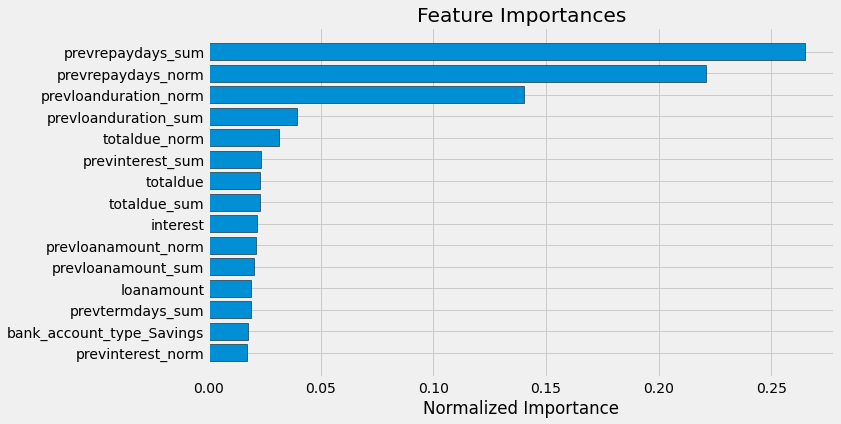

,index,feature,importance,importance_normalized
0,25,prevrepaydays_sum,0.264718,0.264718
1,24,prevrepaydays_norm,0.221139,0.221139
2,28,prevloanduration_norm,0.140251,0.140251
3,29,prevloanduration_sum,0.039557,0.039557
4,20,totaldue_norm,0.031350,0.031350
5,23,previnterest_sum,0.023673,0.023673
6,2,totaldue,0.023124,0.023124
7,21,totaldue_sum,0.022948,0.022948
8,30,interest,0.021666,0.021666
9,18,prevloanamount_norm,0.021367,0.021367


In [108]:
plot_feature_importances(feature_importance)

This gave us a score of 0.2075862068965517 on the board

### XGBOOST

In [109]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, use_label_encoder=False, n_jobs=-1, objective='binary:logistic', 
                     random_state=42, reg_alpha=0.1, reg_lambda=0.1, max_depth=4)

model.fit(train_transformed, y_train)
y_pred = model.predict(test_transformed)
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [110]:
submission.to_csv('xgboost.csv', index=False)

# Approach 2

There are some ways we can improve this. In the earlier work, we noticed that there were a lot of missing data for some columns in the train and test sets after merging with the demographic and prev applications. The approach here is to merge the train and test demographic together & the train and test prev applications together, do feature engineering as above and the merge with the train and test respectively. Let's see if this will give lower missing values

In [111]:
# let's get fresh copies of the dataset

train = pd.read_csv('../input/dataset/trainperf.csv')
test = pd.read_csv('../input/dataset/testperf.csv')

train_demographics = pd.read_csv('../input/dataset/traindemographics.csv')
test_demographics = pd.read_csv('../input/dataset/testdemographics.csv')

train_prev = pd.read_csv('../input/dataset/trainprevloans.csv')
test_prev = pd.read_csv('../input/dataset/testprevloans.csv')


In [112]:
# let's concatenate the datasets
demographics = pd.concat([train_demographics, test_demographics]).reset_index(drop=True)
previous = pd.concat([train_prev, test_prev]).reset_index(drop=True)

demographics.shape, previous.shape

((5833, 9), (24090, 12))

In [113]:
# let's see the missing data in these dataframes
missing_values_table(demographics)

The dataframe has 9 columns.
There are 3 columns with missing values


,Missing Values,% of Missing Values
bank_branch_clients,5768,98.9
level_of_education_clients,5036,86.3
employment_status_clients,865,14.8


In [114]:
missing_values_table(previous)

The dataframe has 12 columns.
There are 1 columns with missing values


,Missing Values,% of Missing Values
referredby,22739,94.4


In [115]:
demographics = demographics.drop(columns=['bank_branch_clients', 'level_of_education_clients'])
previous = previous.drop(columns=['referredby'])

demographics.shape, previous.shape

((5833, 7), (24090, 11))

#### demographics

In [116]:
demographics.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,Permanent
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,Permanent
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,Permanent


In [117]:
# in the case of duplicates on the customer id
duplicate = demographics[demographics.duplicated(subset='customerid')]
 
duplicate


,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,employment_status_clients
159,8a858fca5c35df2c015c39ad8695343e,1980-11-26 00:00:00.000000,Savings,3.352588,7.211089,GT Bank,Permanent
517,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,Permanent
776,8a858f965bb63a25015bbf63fd062e2e,1974-02-25 00:00:00.000000,Savings,3.936366,6.817958,Stanbic IBTC,Permanent
1015,8a858fe65675195a015679452588279c,1982-08-01 00:00:00.000000,Savings,7.533646,9.046885,UBA,Permanent
1090,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,Permanent
1188,8a858fc75cd62882015cdaf2f4311b3f,1975-10-27 00:00:00.000000,Savings,7.437607,9.088935,GT Bank,Permanent
1480,8a858fe05d421ff4015d4c87d2a21ceb,1983-01-20 00:00:00.000000,Savings,8.526960,12.023015,Skye Bank,Permanent
1928,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,Permanent
1996,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,Permanent
4126,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,Permanent


In [118]:
# let's drop the duplicates
demographics.drop_duplicates(subset='customerid', keep='first', inplace=True)

In [119]:
# let's engineer the features from demographics

# encoding categorical features

# bank_name_clients
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
label_encode.fit(demographics['bank_name_clients'])
demographics['bank_name_clients'] = label_encode.transform(demographics['bank_name_clients'])

# bank_account_type
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(demographics[['bank_account_type']])
temp = ohe.transform(demographics[['bank_account_type']]).toarray()
demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
demographics = pd.concat([demographics, demographics_ohe], axis=1).drop(columns=['bank_account_type'])


# employment_status_clients
demographics['employment_status_clients'] = demographics['employment_status_clients'].fillna('NONE')

ohe = OneHotEncoder()
ohe.fit(demographics[['employment_status_clients']])
temp = ohe.transform(demographics[['employment_status_clients']]).toarray()
demographics_ohe = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
demographics = pd.concat([demographics, demographics_ohe], axis=1).drop(columns=['employment_status_clients'])


# drop the longitude gps and latitude gps as earlier
demographics.drop(columns=['latitude_gps', 'longitude_gps'], inplace=True)

demographics.head()

,customerid,birthdate,bank_name_clients,bank_account_type_Current,bank_account_type_Other,bank_account_type_Savings,employment_status_clients_Contract,employment_status_clients_NONE,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,6.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,12.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,4.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [120]:
# let's merge demographics with both the train and test sets

train = train.merge(demographics, on='customerid', how='left') # use only keys present in train
test = test.merge(demographics, on='customerid', how='left') # use only keys present in test

train.shape, test.shape

((4368, 22), (1450, 21))

In [121]:
missing_values_table(train)

The dataframe has 22 columns.
There are 4 columns with missing values


,Missing Values,% of Missing Values
referredby,3781,86.6
bank_account_type_Current,13,0.3
bank_account_type_Other,13,0.3
bank_account_type_Savings,13,0.3


In [122]:
missing_values_table(test)

The dataframe has 21 columns.
There are 4 columns with missing values


,Missing Values,% of Missing Values
referredby,1266,87.3
bank_account_type_Current,2,0.1
bank_account_type_Other,2,0.1
bank_account_type_Savings,2,0.1


As we see this yields a better information than the initial approach in terms of missing values in both the train and test dataset

#### previous

In [123]:
previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [124]:
# deal with dates

date_cols = ['approveddate', 'creationdate', 'closeddate', 'firstduedate', 'firstrepaiddate']
for date in date_cols:
    previous[date] = pd.to_datetime(previous[date]).dt.date


# let's create features based on the dates
previous['loanduration'] = previous['closeddate'] - previous['approveddate']
previous['daysapproved'] = previous['approveddate'] - previous['creationdate']
previous['repaydays'] = previous['firstrepaiddate'] - previous['firstduedate']
previous['interest'] = previous['totaldue'] - previous['loanamount']


# convert those dates to numeric columns

datecols = ['loanduration', 'daysapproved', 'repaydays']

for col in datecols:
    previous[col] = (previous[col] / np.timedelta64(1, 'D')).astype(int)

In [125]:
previous.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,firstduedate,firstrepaiddate,loanduration,daysapproved,repaydays,interest
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15,2016-08-15,10000.0,13000.0,30,2016-09-01,2016-09-14,2016-09-01,17,0,-13,3000.0
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28,2017-04-28,10000.0,13000.0,30,2017-05-28,2017-05-30,2017-05-26,30,0,-4,3000.0
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05,2017-03-05,20000.0,23800.0,30,2017-04-26,2017-04-04,2017-04-26,52,0,22,3800.0
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09,2017-04-09,10000.0,11500.0,15,2017-04-24,2017-04-24,2017-04-24,15,0,0,1500.0
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17,2017-06-17,10000.0,11500.0,15,2017-07-14,2017-07-03,2017-07-14,27,0,11,1500.0


In [126]:
# let's engineer features

prev_cnts = previous.groupby('customerid', as_index=False)['systemloanid'].count().rename(columns={'systemloanid': 'prev_applications'})

# term days
avg_termdays = previous.groupby('customerid', as_index=False)['termdays'].mean().rename(columns={'termdays': 'prevtermdays_norm'})
sum_termdays = previous.groupby('customerid', as_index=False)['termdays'].sum().rename(columns={'termdays': 'prevtermdays_sum'})

# loan amount
avg_loanamnt = previous.groupby('customerid', as_index=False)['loanamount'].mean().rename(columns={'loanamount': 'prevloanamount_norm'})
sum_loanamnt = previous.groupby('customerid', as_index=False)['loanamount'].sum().rename(columns={'loanamount': 'prevloanamount_sum'})

# totaldue
avg_totaldue = previous.groupby('customerid', as_index=False)['totaldue'].mean().rename(columns={'totaldue': 'totaldue_norm'})
sum_totaldue = previous.groupby('customerid', as_index=False)['totaldue'].sum().rename(columns={'totaldue': 'totaldue_sum'})

# interest
avg_interest = previous.groupby('customerid', as_index=False)['interest'].mean().rename(columns={'interest': 'previnterest_norm'})
total_interest = previous.groupby('customerid', as_index=False)['interest'].sum().rename(columns={'interest': 'previnterest_sum'})

# repay days
avg_repaydays = previous.groupby('customerid', as_index=False)['repaydays'].mean().rename(columns={'repaydays': 'prevrepaydays_norm'})
total_repaydays = previous.groupby('customerid', as_index=False)['repaydays'].sum().rename(columns={'repaydays':'prevrepaydays_sum'})

# daysapproved
avg_daysapproved = previous.groupby('customerid', as_index=False)['daysapproved'].mean().rename(columns={'daysapproved': 'prevdaysapproved_norm'})
total_daysapproved = previous.groupby('customerid', as_index=False)['daysapproved'].sum().rename(columns={'daysapproved': 'prevdaysapproved_sum'})

# loanduration
avg_loanduration = previous.groupby('customerid', as_index=False)['loanduration'].mean().rename(columns={'loanduration': 'prevloanduration_norm'})
total_loanduration = previous.groupby('customerid', as_index=False)['loanduration'].sum().rename(columns={'loanduration': 'prevloanduration_sum'})

In [127]:
prev_cnts

,customerid,prev_applications
0,8a1088a0484472eb01484669e3ce4e0b,1
1,8a1a1e7e4f707f8b014f797718316cad,4
2,8a1a32fc49b632520149c3b8fdf85139,7
3,8a1eb5ba49a682300149c3c068b806c7,8
4,8a1edbf14734127f0147356fdb1b1eb2,2
...,...,...
5796,8a858fff5c79144c015c7bdbfc086ce1,1
5797,8aaae7a74400b28201441c8b62514150,3
5798,8aab10f748cf78ff0148d11fac1447a6,1
5799,8aab160f499477da014999ba2f0f578b,3


In [128]:
# let's merge these features
prev_features = prev_cnts.merge(avg_termdays, on='customerid', how='inner')
prev_features = prev_features.merge(sum_termdays, on='customerid', how='inner')
prev_features = prev_features.merge(avg_loanamnt, on='customerid', how='inner')
prev_features = prev_features.merge(sum_loanamnt, on='customerid', how='inner')
prev_features = prev_features.merge(avg_totaldue, on='customerid', how='inner')
prev_features = prev_features.merge(sum_totaldue, on='customerid', how='inner')
prev_features = prev_features.merge(avg_interest, on='customerid', how='inner')
prev_features = prev_features.merge(total_interest, on='customerid', how='inner')
prev_features = prev_features.merge(avg_repaydays, on='customerid', how='inner')
prev_features = prev_features.merge(total_repaydays, on='customerid', how='inner')
prev_features = prev_features.merge(avg_daysapproved, on='customerid', how='inner')
prev_features = prev_features.merge(total_daysapproved, on='customerid', how='inner')
prev_features = prev_features.merge(avg_loanduration, on='customerid', how='inner')
prev_features = prev_features.merge(total_loanduration, on='customerid', how='inner')

prev_features.head()

,customerid,prev_applications,prevtermdays_norm,prevtermdays_sum,prevloanamount_norm,prevloanamount_sum,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a1088a0484472eb01484669e3ce4e0b,1,15.000000,15,10000.000000,10000.0,11500.000000,11500.0,1500.000000,1500.0,6.000000,6,0.0,0,22.000,22
1,8a1a1e7e4f707f8b014f797718316cad,4,37.500000,150,17500.000000,70000.0,22375.000000,89500.0,4875.000000,19500.0,-0.250000,-1,0.0,0,31.750,127
2,8a1a32fc49b632520149c3b8fdf85139,7,19.285714,135,12857.142857,90000.0,15214.285714,106500.0,2357.142857,16500.0,-0.428571,-3,0.0,0,19.000,133
3,8a1eb5ba49a682300149c3c068b806c7,8,33.750000,270,16250.000000,130000.0,20300.000000,162400.0,4050.000000,32400.0,-3.125000,-25,0.0,0,28.625,229
4,8a1edbf14734127f0147356fdb1b1eb2,2,22.500000,45,10000.000000,20000.0,12250.000000,24500.0,2250.000000,4500.0,-4.000000,-8,0.0,0,18.500,37


In [129]:
prev_features.shape

(5801, 16)

In [130]:
# let's merge on the train and test sets 
print(train.shape, test.shape)

train = train.merge(prev_features, on='customerid', how='left') # use keys only from the train
test = test.merge(prev_features, on='customerid', how='left') # use only keys from test

print(train.shape, test.shape)

(4368, 22) (1450, 21)
(4368, 37) (1450, 36)


### Train and Test

In [131]:
train.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,...,totaldue_norm,totaldue_sum,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good,...,22081.818182,242900.0,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good,...,11750.000000,70500.0,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good,...,12250.000000,24500.0,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good,...,23550.000000,188400.0,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0


In [132]:
missing_values_table(train)

The dataframe has 37 columns.
There are 19 columns with missing values


,Missing Values,% of Missing Values
referredby,3781,86.6
bank_account_type_Other,13,0.3
bank_account_type_Savings,13,0.3
bank_account_type_Current,13,0.3
previnterest_norm,9,0.2
prevloanduration_norm,9,0.2
prevdaysapproved_sum,9,0.2
prevdaysapproved_norm,9,0.2
prevrepaydays_sum,9,0.2
prevrepaydays_norm,9,0.2


In [133]:
missing_values_table(test)

The dataframe has 36 columns.
There are 19 columns with missing values


,Missing Values,% of Missing Values
referredby,1266,87.3
totaldue_sum,8,0.6
prevloanduration_norm,8,0.6
prevdaysapproved_sum,8,0.6
prevdaysapproved_norm,8,0.6
prevrepaydays_sum,8,0.6
prevrepaydays_norm,8,0.6
previnterest_sum,8,0.6
previnterest_norm,8,0.6
totaldue_norm,8,0.6


In [134]:
# the only feature with high enough missing values is the referredby feature, let's drop it
train = train.drop(columns=['referredby'])
test = test.drop(columns=['referredby'])

# let's deal with the date cols here 
date_cols = ['approveddate', 'creationdate', 'birthdate']

for date in date_cols:
    train[date] = pd.to_datetime(train[date]).dt.normalize()

test['birthdate'] = pd.to_datetime(test['birthdate']).dt.normalize()

# let's create the Interest attribute
train['interest'] = train['totaldue'] - train['loanamount']
test['interest'] = test['totaldue'] - test['loanamount']

# let's create the Age attribute
last_day = train['approveddate'].max().year
print(last_day)

train['Age'] = last_day - train['birthdate'].dt.year
test['Age'] = last_day - test['birthdate'].dt.year

2017


In [135]:
train.shape, test.shape

((4368, 38), (1450, 37))

In [136]:
# drop some columns
train = train.drop(columns=['creationdate', 'approveddate', 'birthdate'])
test = test.drop(columns=['creationdate', 'approveddate', 'birthdate'])

In [137]:
train.head()

,customerid,systemloanid,loannumber,loanamount,totaldue,termdays,good_bad_flag,bank_name_clients,bank_account_type_Current,bank_account_type_Other,...,previnterest_norm,previnterest_sum,prevrepaydays_norm,prevrepaydays_sum,prevdaysapproved_norm,prevdaysapproved_sum,prevloanduration_norm,prevloanduration_sum,interest,Age
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,30000.0,34500.0,30,Good,1.0,0.0,0.0,...,3900.0,42900.0,-0.909091,-10.0,0.0,0.0,30.000000,330.0,4500.0,45
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,15000.0,17250.0,30,Good,6.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2250.0,32
2,8a8588f35438fe12015444567666018e,301966580,7,20000.0,22250.0,15,Good,2.0,0.0,1.0,...,1750.0,10500.0,0.833333,5.0,0.0,0.0,18.833333,113.0,2250.0,33
3,8a85890754145ace015429211b513e16,301999343,3,10000.0,11500.0,15,Good,5.0,0.0,1.0,...,2250.0,4500.0,7.500000,15.0,0.0,0.0,31.500000,63.0,1500.0,40
4,8a858970548359cc0154883481981866,301962360,9,40000.0,44000.0,30,Good,6.0,0.0,0.0,...,4800.0,38400.0,-3.125000,-25.0,0.0,0.0,27.375000,219.0,4000.0,31


In [138]:
# let's align the dataframes
target = train['good_bad_flag']
train, test = train.align(test, join='inner', axis=1)

train.shape, test.shape

((4368, 34), (1450, 34))

In [139]:
target = target.map({'Good': 1, 'Bad': 0})
target.head()

0    1
1    1
2    1
3    1
4    1
Name: good_bad_flag, dtype: int64

In [140]:
target.value_counts()

1    3416
0     952
Name: good_bad_flag, dtype: int64

In [141]:
missing_values_table(train)

The dataframe has 34 columns.
There are 18 columns with missing values


,Missing Values,% of Missing Values
bank_account_type_Current,13,0.3
bank_account_type_Savings,13,0.3
bank_account_type_Other,13,0.3
previnterest_norm,9,0.2
prevloanduration_norm,9,0.2
prevdaysapproved_sum,9,0.2
prevdaysapproved_norm,9,0.2
prevrepaydays_sum,9,0.2
prevrepaydays_norm,9,0.2
previnterest_sum,9,0.2


In [142]:
missing_values_table(test)

The dataframe has 34 columns.
There are 18 columns with missing values


,Missing Values,% of Missing Values
totaldue_sum,8,0.6
previnterest_norm,8,0.6
prevloanduration_norm,8,0.6
prevdaysapproved_sum,8,0.6
prevdaysapproved_norm,8,0.6
prevrepaydays_sum,8,0.6
prevrepaydays_norm,8,0.6
previnterest_sum,8,0.6
prevloanduration_sum,8,0.6
totaldue_norm,8,0.6


In this second approach, we've been able to extract better information better than the first approach. This is because of an error in the way the dataset was constructed. Let's see the correlation of these features with the target

In [143]:
train['good_bad_flag'] = target

corr = train.corr()['good_bad_flag']
corr.sort_values(ascending=False)

good_bad_flag                              1.000000
loanamount                                 0.115267
totaldue                                   0.108357
prevloanamount_norm                        0.104491
totaldue_norm                              0.101617
loannumber                                 0.090487
totaldue_sum                               0.089926
prev_applications                          0.089844
prevloanamount_sum                         0.089563
previnterest_sum                           0.089024
prevtermdays_sum                           0.086625
Age                                        0.055091
employment_status_clients_Permanent        0.053131
previnterest_norm                          0.051034
prevloanduration_sum                       0.043717
interest                                   0.032540
employment_status_clients_Self-Employed    0.026363
prevtermdays_norm                          0.015887
bank_account_type_Savings                  0.012528
employment_s

In [144]:
# let's save the files
train.to_csv('trainfinal.csv', index=False)
test.to_csv('testfinal.csv', index=False)

### Modelling

In [145]:
if 'good_bad_flag' in train:
    train = train.drop(columns=['good_bad_flag'])
else:
    train = train.copy()
    
train.shape, test.shape

((4368, 34), (1450, 34))

In [146]:
X_train = train.drop(columns=['customerid', 'systemloanid'])
X_test = test.drop(columns=['customerid', 'systemloanid'])
y_train = target
test_ids = test['customerid']
features = X_train.columns

#### Random Forest Model

In [147]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

y_train = target
y_train = np.array(y_train)
pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

model.fit(train_transformed, y_train)
y_pred = model.predict(test_transformed)

In [148]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [149]:
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [150]:
submission.to_csv('randomforest2.csv', index=False)

This gave a 0.210344 on the board. This is good.

In [151]:
# let's tune it now
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

pipeline.fit(X_train)
train_transformed = pipeline.transform(X_train)
test_transformed = pipeline.transform(X_test)

model = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42)

param_grid = [{'n_estimators': [50, 100, 200, 300], 'max_depth': [4, 5, 6, 7], 'max_features': [4, 5, 6, 8, 10]}]
grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5)
grid_search.fit(train_transformed, y_train)
grid_search.best_params_

{'max_depth': 4, 'max_features': 4, 'n_estimators': 200}

In [152]:
model = model = RandomForestClassifier(n_estimators=1000, max_depth=4, max_features=6, n_jobs=-1, random_state=42)
model.fit(train_transformed, y_train)

y_pred = model.predict(test_transformed)
submission = pd.DataFrame({'customerid': test_ids, 'Good_Bad_flag': y_pred})
submission.head()

,customerid,Good_Bad_flag
0,8a858899538ddb8e015390510b321f08,1
1,8a858959537a097401537a4e316e25f7,1
2,8a8589c253ace09b0153af6ba58f1f31,1
3,8a858e095aae82b7015aae86ca1e030b,1
4,8a858e225a28c713015a30db5c48383d,1


In [153]:
submission.to_csv('randomforesttunedd.csv', index=False)

This gave a score of 0.2048275862068 on the board.